# DenseNet
Verilerimizi DenseNet'in 4 versiyonu ile eğiticez.
- DenseNet 121
- DenseNet 201
- DenseNet 161
- DenseNet 169

#### Google Colab Doğrulama

3 tane datasetimiz var. Onlara ulaşabilmek adına doğrulama işlemlerini gerçekleştiriyoruz.


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Bağlanıp bağlanmadığımız görmek amacıyla drive daki çalışma alanımızın içindekileri listele komutunu çalıştırıyoruz.

In [ ]:
ls "/content/drive/My Drive/CT"

checkpoint    denseNet_model_78.h5               my_model_fra.h5  transfer/
covid/        earlystop_model.h5                 non-covid/       works/
COVID/        model.h5                           NonCOVID/
CT_COVID/     model_weights.data-00000-of-00001  Normalize/
CT_NonCOVID/  model_weights.index                saved_models/


#### Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121, MobileNetV2


from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import keras
import tensorflow as tf

from keras.callbacks import ModelCheckpoint, EarlyStopping

Normalize edilmiş değerleri önceki ipynb dosyamızda npy olarak kaydetmiştik. Bu aşama, işlemlerimizi hızlandırmak için yapıldı. numpy kütüphanesinden load() metodunu çağırarak normalize olmuş datamızı kullanmaya başlayabiliriz.

In [ ]:
a= "/content/drive/My Drive/CT/Normalize/"

#300 veri bulunan dataset
l1x=a+ "X_nparray300.npy"
l1y=a+ "y_nparray300.npy"

#1200 veri bulunan dataset
l2x=a+ "X_nparray1200.npy"
l2y=a+ "y_nparray1200.npy"

#3000 veri bulunan dataset
l3x=a+ "X_nparray3000.npy"
l3y=a+ "y_nparray3000.npy"

loaded_array_x1200 = np.load(l2x)
loaded_array_y1200 = np.load(l2y)

In [ ]:
X=loaded_array_x1200
y=loaded_array_y1200

Datamızın doğru yüklendiğine emin olmak için shape metodunu kullanarak inceliyoruz.

In [ ]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2481, 64, 64, 3) and shape of target variable: (2481, 2)


Verisetimiz üzerinde kaç tane forward ve backward propagation yapılacağını ayarladığımız apoch sayımızı 50,100 ve 200 vereceğiz.

Tüm veri kümesini aynı anda sinir ağına veremeyeceğimiz için dataseti parçalara böleriz. Yani batch size olarak adlandırdığımız bu hiperparametre üzerinde çalışılacak bir parti örneğin miktarını bize söyler. Burada 64'er adet image lar halinde modelimize göndereceğiz.

In [ ]:
EPOCHS = 100
# 50, 100, 200
SIZE=64
N_ch=3
BATCH_SIZE = 64
SEED= 42

IMG_W= 64
IMG_H= 64
CHANNELS = 3

INPUT_SHAPE=(IMG_W, IMG_H, CHANNELS)

# Optimizers
Optimizer'lar kayıpları azaltmak için sinir ağının ağırlıklarını ve öğrenme hızını değiştirmek için kullanılan algoritmalardır. 

- SGD
- RMSprop
- Adam
- Adadelta
- Adagrad
- Adamax
- Nadam

# DenseNet 121

## 1. SGD


```

optimizer =  tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD", **kwargs
)

```



In [ ]:
import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer =  tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()




Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2624

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)


In [ ]:
len(X_train)

1736

In [ ]:
len(X_val)

745

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))



        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 14s - loss: 0.9231 - accuracy: 0.5754 - val_loss: 0.7362 - val_accuracy: 0.5946

Epoch 00001: val_loss improved from inf to 0.73624, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 0.8045 - accuracy: 0.6400 - val_loss: 0.6776 - val_accuracy: 0.6349

Epoch 00002: val_loss improved from 0.73624 to 0.67764, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 3s - loss: 0.7392 - accuracy: 0.6719 - val_loss: 0.6846 - val_accuracy: 0.6027

Epoch 00003: val_loss did not improve from 0.67764
Epoch 4/100
27/27 - 3s - loss: 0.6587 - accuracy: 0.7249 - val_loss: 0.6378 - val_accuracy: 0.6470

Epoch 00004: val_loss improved from 0.67764 to 0.63781, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 3s - loss: 0.5971 - accuracy: 0.7476 - val_loss: 0.7375 - val_accuracy: 0.5866

Epoch 00005: val_loss did not improve from 0.63781
Epoch 6/100
27/27 - 3s - loss: 0.5519 - accuracy: 0.7632 - val_loss: 0.6555 - val_accuracy: 0.6403

Epoch 00006: val_loss did not improve from 

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.9007176756858826
validation_accuracy =  0.8939597606658936
training_loss   =  0.24382610619068146
validation_loss =  0.25781407952308655


## Accuracy ve Loss değerlerinin görselleştirilmeleri

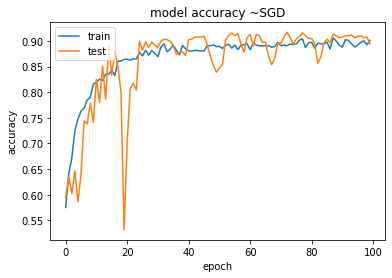

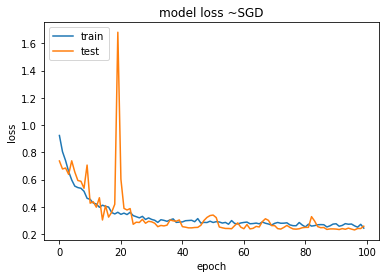

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~SGD')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~SGD')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sonuçlar

**Accuracy**:
**Precision**: Yanlış Pozitifin maliyetinin ne kadar yüksek olduğunu belirlemek için kullanılır.<br>
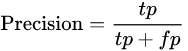 <br>
**Recall**: Pozitif olarak etiketleyerek kaç tane Gerçek Pozitif yakalandığını hesaplar.<br>
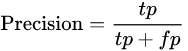<br>

**F1-score**: Hassasiyet(Precision) ve Recall'un ağırlıklı ortalamasıdır.<br>
F1 = 2 × (precision × recall) / (precision + recall)

**Cohen's Kappa**:

**ROC AUC**: ROC eğrisinin altında kalan alan olan AUC tahminler doğrulaştıkça 1 noktasına doğru gitme eğilimindedir.

**R2**:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.893960
Precision: 0.914773
Recall: 0.867925
F1 score: 0.890733
Cohens kappa: 0.787872
ROC AUC: 0.893855
Precision =  0.915
[[344  30]
 [ 49 322]]


In [ ]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.7378 MSE: 0.0656
Test R2 Score:    0.6724 MSE: 0.0819


### Karmaşıklık Matrisi

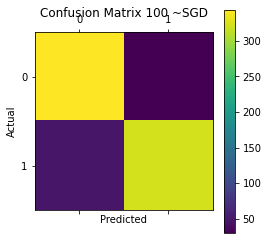

In [ ]:
plt.matshow(cf)
plt.title('Confusion Matrix 100 ~SGD')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

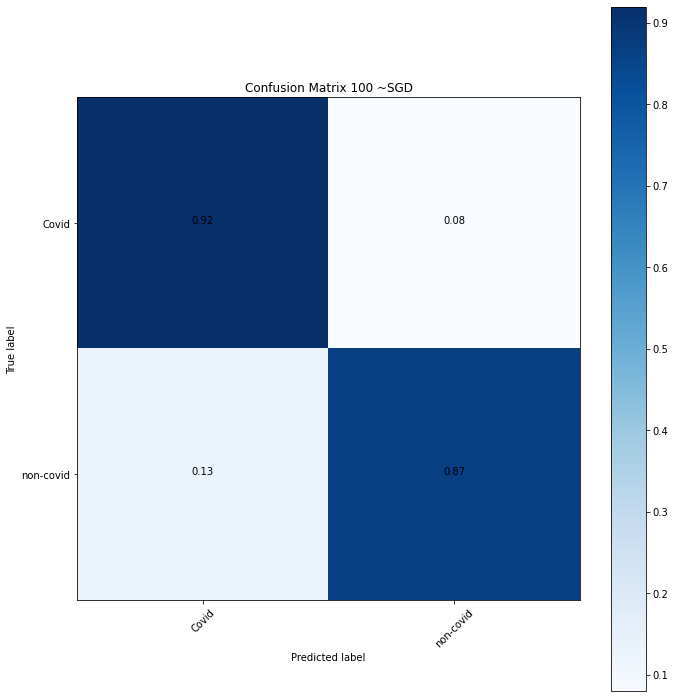

In [ ]:


class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~SGD', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~SGD')
plt.show()

#### ROC AUC Score

roc_auc_score for Model:  0.8938553122792857


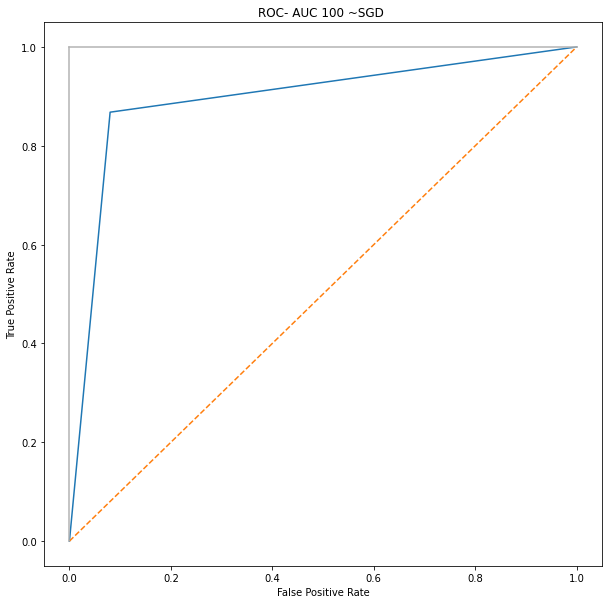

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~SGD ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

## 2. RMSprop


```

optimizer =   tf.keras.optimizers.RMSprop()

```


In [ ]:
import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer =   tf.keras.optimizers.RMSprop()
 
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2624

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 23s - loss: 0.7661 - accuracy: 0.6591 - val_loss: 29.5685 - val_accuracy: 0.5020

Epoch 00001: val_loss improved from inf to 29.56853, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 0.5728 - accuracy: 0.7356 - val_loss: 911.7399 - val_accuracy: 0.5020

Epoch 00002: val_loss did not improve from 29.56853
Epoch 3/100
27/27 - 3s - loss: 0.5463 - accuracy: 0.7708 - val_loss: 64.9202 - val_accuracy: 0.6255

Epoch 00003: val_loss did not improve from 29.56853
Epoch 4/100
27/27 - 3s - loss: 0.5010 - accuracy: 0.7817 - val_loss: 31.8040 - val_accuracy: 0.4268

Epoch 00004: val_loss did not improve from 29.56853
Epoch 5/100
27/27 - 3s - loss: 0.4884 - accuracy: 0.7967 - val_loss: 21.1668 - val_accuracy: 0.4497

Epoch 00005: val_loss improved from 29.56853 to 21.16679, saving model to model_CNN2.h5
Epoch 6/100
27/27 - 3s - loss: 0.4564 - accuracy: 0.8080 - val_loss: 25.8680 - val_accuracy: 0.6604

Epoch 00006: val_loss did not improve from 21.16679
Epoch 7/100
2

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.9491626620292664
validation_accuracy =  0.6617449522018433
training_loss   =  0.12378299981355667
validation_loss =  1.3730416297912598


# Görselleştirmeler

# Accuracy ve Loss değerlerinin görselleştirilmeleri

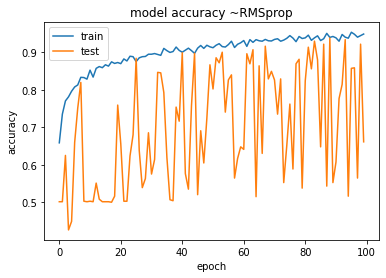

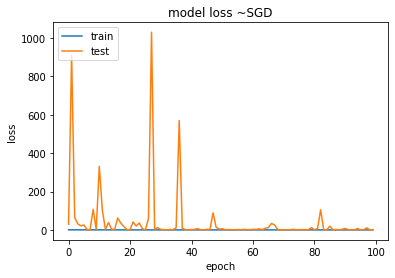

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~RMSprop')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~RMSprop')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Metrik Sonuçları

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.661745
Precision: 0.894040
Recall: 0.363881
F1 score: 0.517241
Cohens kappa: 0.321866
ROC AUC: 0.660550
Precision =  0.894
[[358  16]
 [236 135]]


# R2 & MSE

In [ ]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: -0.2796 MSE: 0.3199
Test R2 Score:   -0.2575 MSE: 0.3144


# Karmaşıklık Matrisi

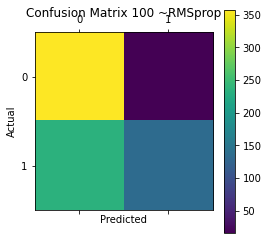

In [ ]:
plt.matshow(cf)
plt.title('Confusion Matrix 100 ~RMSprop')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Figure size 432x288 with 0 Axes>

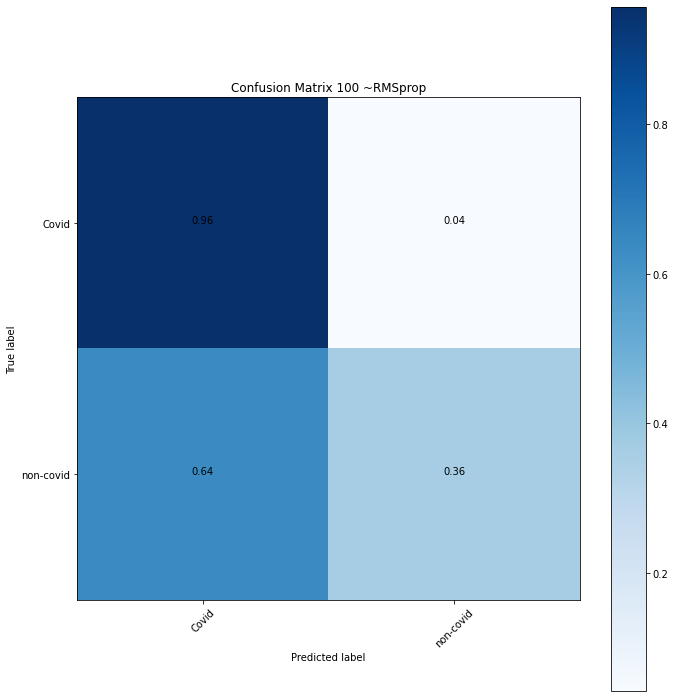

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~SGD', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~RMSprop')
plt.show()

# ROC-AUC Score

roc_auc_score for Model:  0.6605503264770746


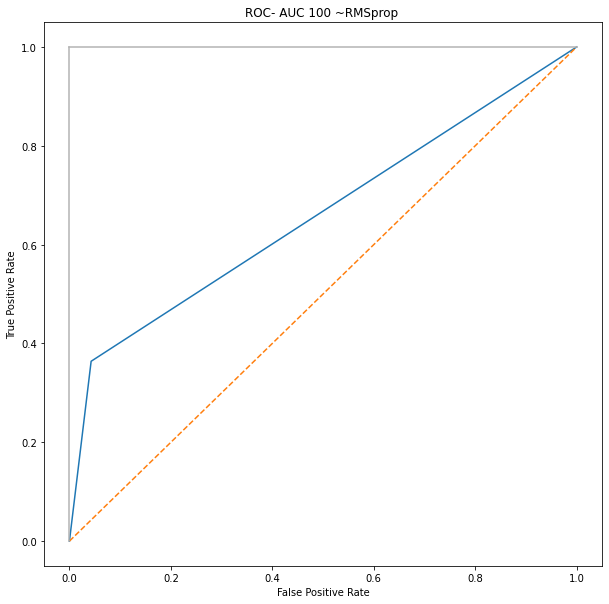

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~RMSprop ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

## 3. Adam


```

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

```

In [ ]:
import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2624

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 16s - loss: 1.2308 - accuracy: 0.5885 - val_loss: 5582799872208267359813632.0000 - val_accuracy: 0.5020

Epoch 00001: val_loss improved from inf to 5582799872208267359813632.00000, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 0.5809 - accuracy: 0.7165 - val_loss: 547520806912.0000 - val_accuracy: 0.5020

Epoch 00002: val_loss improved from 5582799872208267359813632.00000 to 547520806912.00000, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 3s - loss: 0.5172 - accuracy: 0.7566 - val_loss: 42826676.0000 - val_accuracy: 0.5020

Epoch 00003: val_loss improved from 547520806912.00000 to 42826676.00000, saving model to model_CNN2.h5
Epoch 4/100
27/27 - 3s - loss: 0.5213 - accuracy: 0.7434 - val_loss: 230861.3125 - val_accuracy: 0.5020

Epoch 00004: val_loss improved from 42826676.00000 to 230861.31250, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 3s - loss: 0.5513 - accuracy: 0.7374 - val_loss: 16573.9160 - val_accuracy: 0.5020

Epoch 00005: val_lo

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.8881579041481018
validation_accuracy =  0.8966442942619324
training_loss   =  0.2500634491443634
validation_loss =  0.30993539094924927


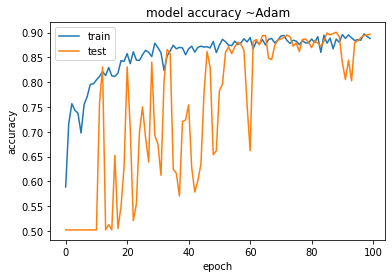

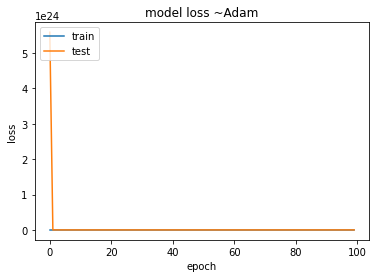

In [ ]:
# Accuracy ve Loss değerlerinin görselleştirilmeleri

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~Adam')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Metrik Sonuçları

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.896644
Precision: 0.901639
Recall: 0.889488
F1 score: 0.895522
Cohens kappa: 0.793274
ROC AUC: 0.896616
Precision =  0.902
[[338  36]
 [ 41 330]]


In [ ]:
# R2 & MSE

def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.7395 MSE: 0.0651
Test R2 Score:    0.6888 MSE: 0.0778


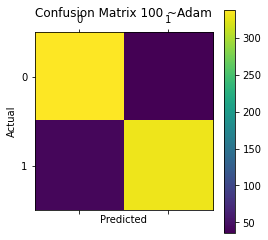

In [ ]:
# Karmaşıklık Matrisi

plt.matshow(cf)
plt.title('Confusion Matrix 100 ~Adam')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

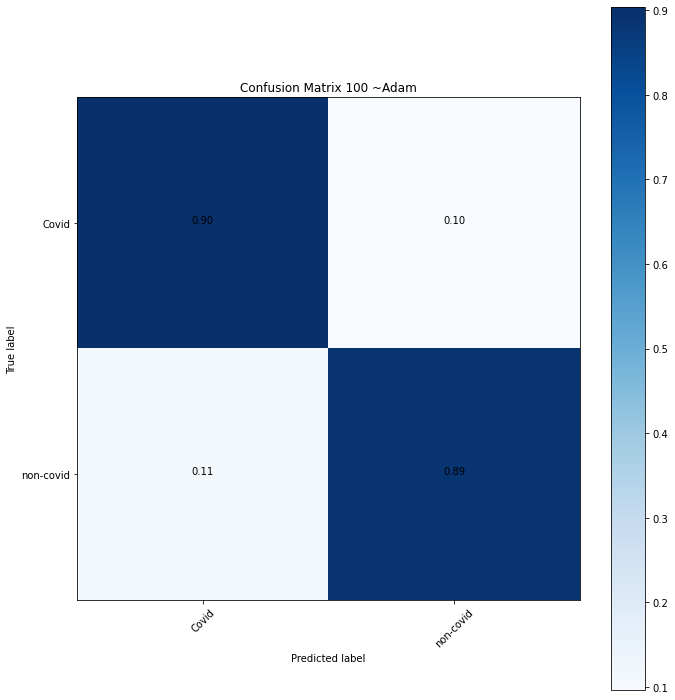

In [ ]:
class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~Adam', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~Adam')
plt.show()

roc_auc_score for Model:  0.8966155930639839


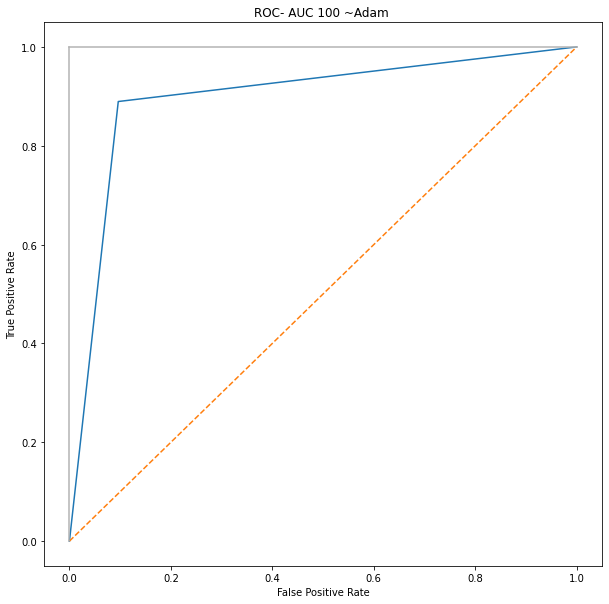

In [ ]:
# ROC-AUC Score

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~Adam ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

## 3. Adadelta


```
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001)
```

In [ ]:
import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001)
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_10  (None, 1024)              0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 15s - loss: 1.0446 - accuracy: 0.5018 - val_loss: 0.7874 - val_accuracy: 0.4940

Epoch 00001: val_loss improved from inf to 0.78743, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 1.0832 - accuracy: 0.4964 - val_loss: 0.7414 - val_accuracy: 0.5275

Epoch 00002: val_loss improved from 0.78743 to 0.74137, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 3s - loss: 1.0848 - accuracy: 0.4757 - val_loss: 0.7530 - val_accuracy: 0.5302

Epoch 00003: val_loss did not improve from 0.74137
Epoch 4/100
27/27 - 3s - loss: 1.0771 - accuracy: 0.4850 - val_loss: 0.7678 - val_accuracy: 0.5168

Epoch 00004: val_loss did not improve from 0.74137
Epoch 5/100
27/27 - 3s - loss: 1.0449 - accuracy: 0.4886 - val_loss: 0.7765 - val_accuracy: 0.5060

Epoch 00005: val_loss did not improve from 0.74137
Epoch 6/100
27/27 - 3s - loss: 1.0401 - accuracy: 0.5144 - val_loss: 0.7798 - val_accuracy: 0.5141

Epoch 00006: val_loss did not improve from 0.74137
Epoch 7/100
27/27 - 3s - lo

### Adadelta Sonuçlar

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.584330141544342
validation_accuracy =  0.6402684450149536
training_loss   =  0.9056424498558044
validation_loss =  0.6956102252006531


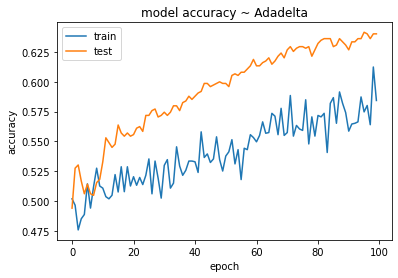

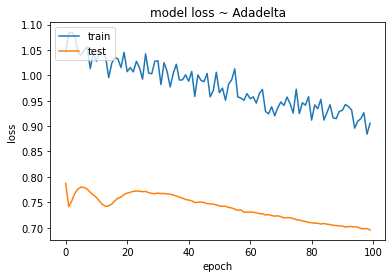

In [ ]:
# Accuracy ve Loss değerlerinin görselleştirilmeleri

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~ Adadelta')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~ Adadelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Metrik Sonuçları

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)


Accuracy: 0.640268
Precision: 0.617849
Recall: 0.727763
F1 score: 0.668317
Cohens kappa: 0.281038
ROC AUC: 0.640619
Precision =  0.618
[[207 167]
 [101 270]]


In [ ]:
# R2 & MSE

def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.0283 MSE: 0.2429
Test R2 Score:    0.0305 MSE: 0.2424


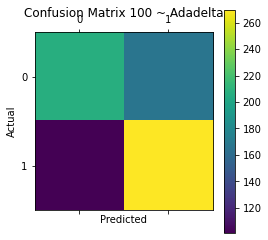

In [ ]:
# Karmaşıklık Matrisi

plt.matshow(cf)
plt.title('Confusion Matrix 100 ~ Adadelta')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

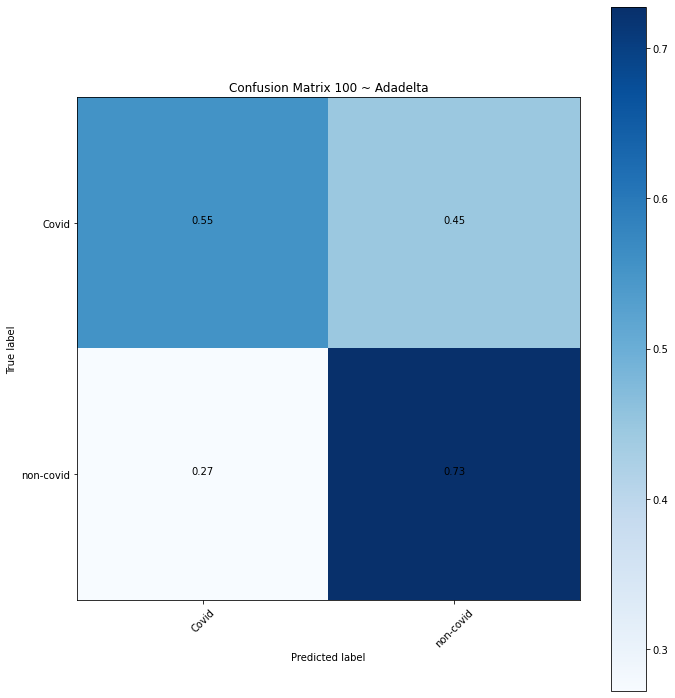

In [ ]:
class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~ Adadelta', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~ Adadelta')
plt.show()

roc_auc_score for Model:  0.6406193695316892


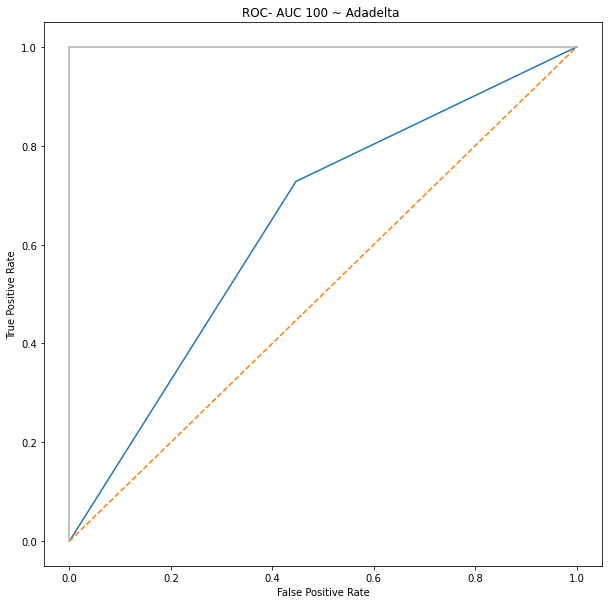

In [ ]:
# ROC-AUC Score

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~ Adadelta ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

## 5. Adagrad


```
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
```

In [ ]:

import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_11  (None, 1024)              0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               262

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
                      
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 14s - loss: 1.0170 - accuracy: 0.5295 - val_loss: 1.0992 - val_accuracy: 0.4671

Epoch 00001: val_loss improved from inf to 1.09924, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 0.9413 - accuracy: 0.5664 - val_loss: 0.8700 - val_accuracy: 0.4483

Epoch 00002: val_loss improved from 1.09924 to 0.87005, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 3s - loss: 0.8848 - accuracy: 0.5897 - val_loss: 0.7572 - val_accuracy: 0.4980

Epoch 00003: val_loss improved from 0.87005 to 0.75721, saving model to model_CNN2.h5
Epoch 4/100
27/27 - 3s - loss: 0.8349 - accuracy: 0.6304 - val_loss: 0.7004 - val_accuracy: 0.5839

Epoch 00004: val_loss improved from 0.75721 to 0.70043, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 3s - loss: 0.8100 - accuracy: 0.6370 - val_loss: 0.6489 - val_accuracy: 0.6698

Epoch 00005: val_loss improved from 0.70043 to 0.64888, saving model to model_CNN2.h5
Epoch 6/100
27/27 - 3s - loss: 0.7563 - accuracy: 0.6830 - val_loss: 0.62

# Adagrad Sonuçlar

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.8797847032546997
validation_accuracy =  0.9127516746520996
training_loss   =  0.31375008821487427
validation_loss =  0.2376812845468521


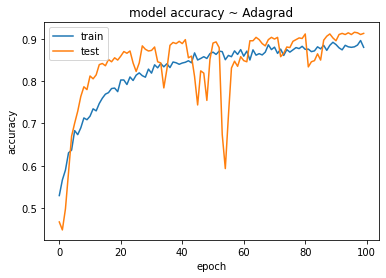

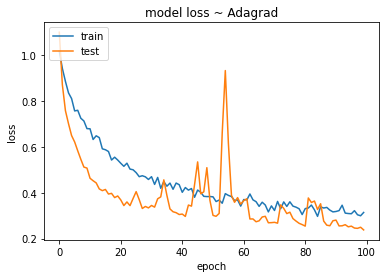

In [ ]:
# Accuracy ve Loss değerlerinin görselleştirilmeleri

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~ Adagrad')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~ Adagrad')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# Metrik Sonuçları

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)


Accuracy: 0.912752
Precision: 0.900524
Recall: 0.927224
F1 score: 0.913679
Cohens kappa: 0.825521
ROC AUC: 0.912810
Precision =  0.901
[[336  38]
 [ 27 344]]


In [ ]:
# R2 & MSE

def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")


Train R2 Score: 0.7850 MSE: 0.0537
Test R2 Score:    0.7384 MSE: 0.0654


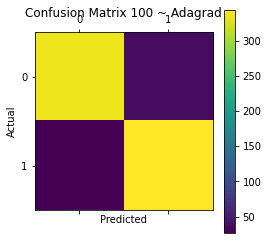

In [ ]:
# Karmaşıklık Matrisi

plt.matshow(cf)
plt.title('Confusion Matrix 100 ~ Adagrad')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

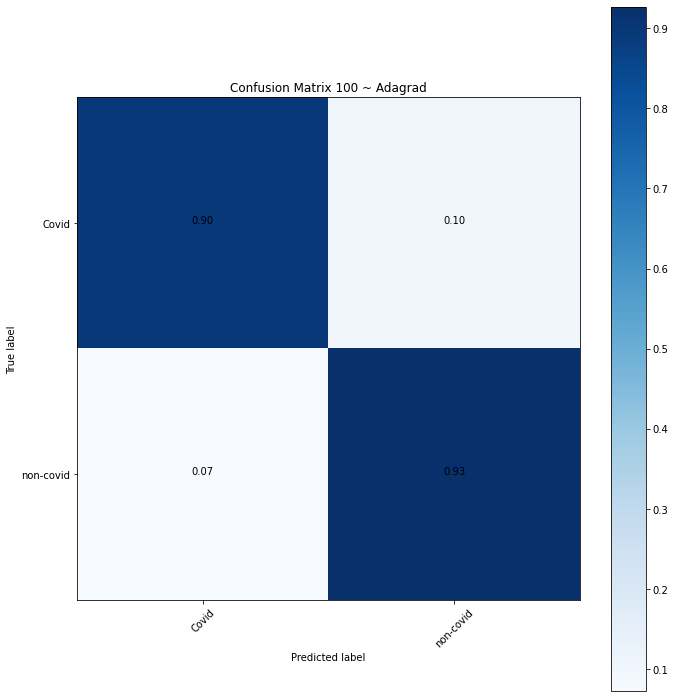

In [ ]:
class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~ Adagrad', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~ Adagrad')
plt.show()

roc_auc_score for Model:  0.9128097208008418


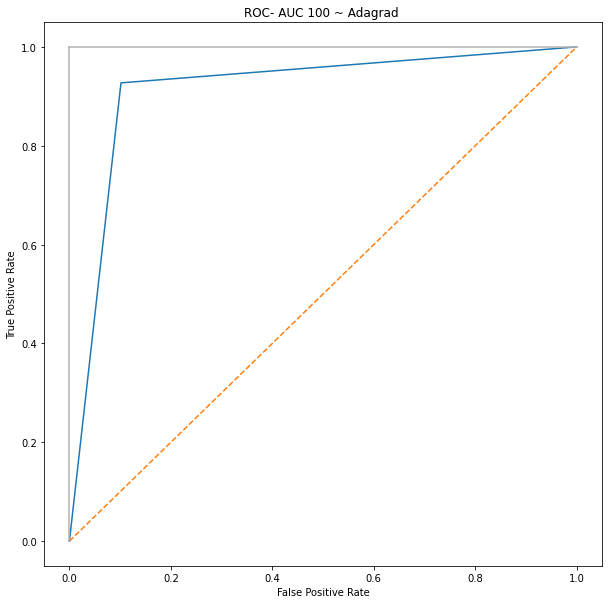

In [ ]:
# ROC-AUC Score

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~ Adagrad ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

## 6. Nadam


```
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
```

In [ ]:

import keras
import tensorflow as tf

def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_densenet121()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_13  (None, 1024)              0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               262

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 34s - loss: 0.8306 - accuracy: 0.6262 - val_loss: 3.0487 - val_accuracy: 0.4980

Epoch 00001: val_loss improved from inf to 3.04873, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 4s - loss: 0.6082 - accuracy: 0.7512 - val_loss: 3.1848 - val_accuracy: 0.5007

Epoch 00002: val_loss did not improve from 3.04873
Epoch 3/100
27/27 - 4s - loss: 0.4801 - accuracy: 0.8110 - val_loss: 2.1755 - val_accuracy: 0.5584

Epoch 00003: val_loss improved from 3.04873 to 2.17545, saving model to model_CNN2.h5
Epoch 4/100
27/27 - 4s - loss: 0.5856 - accuracy: 0.7530 - val_loss: 0.7535 - val_accuracy: 0.5490

Epoch 00004: val_loss improved from 2.17545 to 0.75350, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 4s - loss: 0.5257 - accuracy: 0.7817 - val_loss: 0.8191 - val_accuracy: 0.6161

Epoch 00005: val_loss did not improve from 0.75350
Epoch 6/100
27/27 - 4s - loss: 0.4138 - accuracy: 0.8122 - val_loss: 0.8034 - val_accuracy: 0.6403

Epoch 00006: val_loss did not improve from 

## Nadam Sonuçlar

In [ ]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.9228469133377075
validation_accuracy =  0.9315436482429504
training_loss   =  0.18969912827014923
validation_loss =  0.5324631929397583


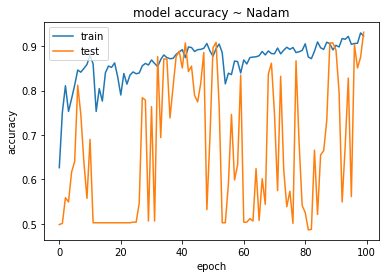

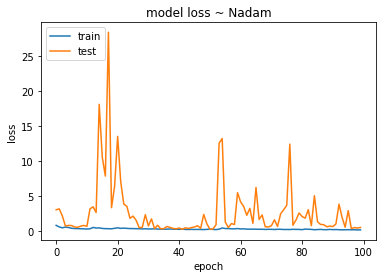

In [ ]:
# Accuracy ve Loss değerlerinin görselleştirilmeleri

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~ Nadam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~ Nadam')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Metrik Sonuçları

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.931544
Precision: 0.916667
Recall: 0.948787
F1 score: 0.932450
Cohens kappa: 0.863104
ROC AUC: 0.931613
Precision =  0.917
[[342  32]
 [ 19 352]]


In [ ]:
# R2 & MSE

def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.7791 MSE: 0.0552
Test R2 Score:    0.7502 MSE: 0.0624


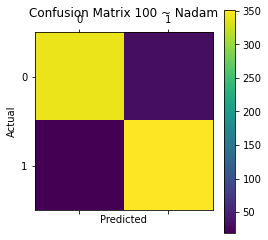

In [ ]:

# Karmaşıklık Matrisi

plt.matshow(cf)
plt.title('Confusion Matrix 100 ~ Nadam')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Figure size 432x288 with 0 Axes>

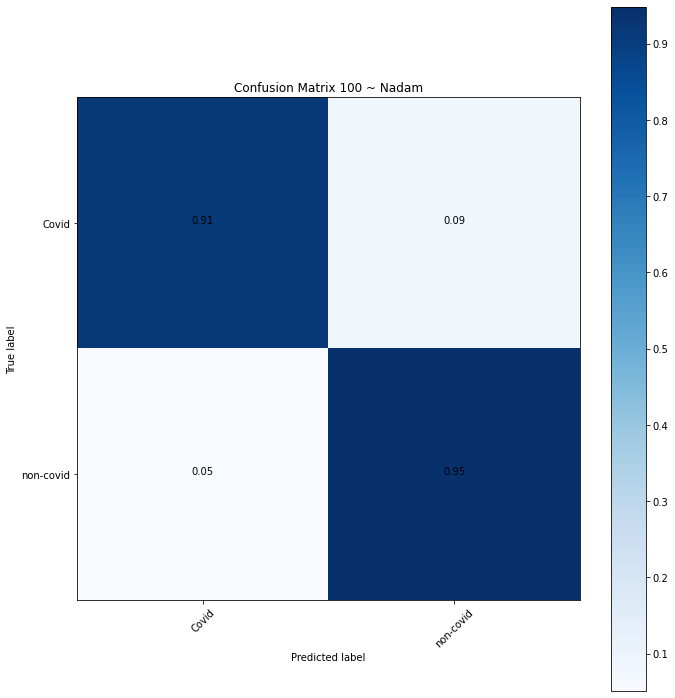

In [ ]:
class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion Matrix 100 ~ Nadam', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix 100 ~ Nadam')
plt.show()

roc_auc_score for Model:  0.931612782334203


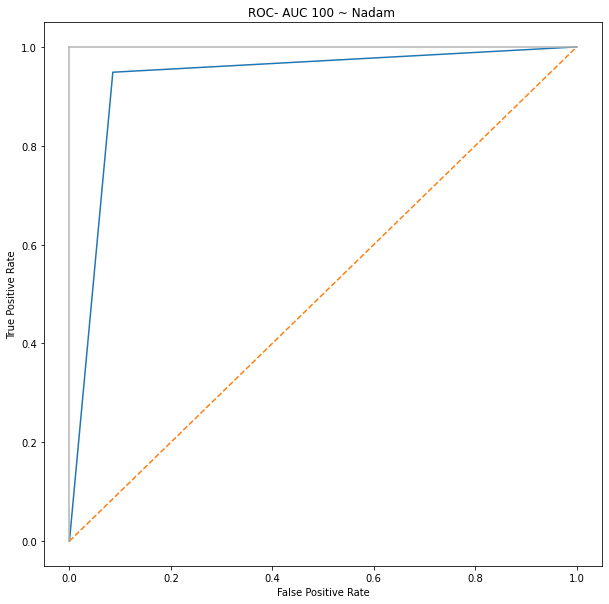

In [ ]:
# ROC-AUC Score

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC 100 ~ Nadam ')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# SONUÇ



```
×××××××××××××××××××××××××××××××××××××××××××××××××SGD


training_accuracy   =  0.9007176756858826
validation_accuracy =  0.8939597606658936
training_loss   =  0.24382610619068146
validation_loss =  0.25781407952308655

Accuracy: 0.893960
Precision: 0.914773
Recall: 0.867925
F1 score: 0.890733
Cohens kappa: 0.787872
ROC AUC: 0.893855
Precision =  0.915
[[344  30]
 [ 49 322]]


Train R2 Score: 0.7378 MSE: 0.0656
Test R2 Score:    0.6724 MSE: 0.0819


×××××××××××××××××××××××××××××××××××××××××××××××××RMSprop

training_accuracy   =  0.9491626620292664
validation_accuracy =  0.6617449522018433
training_loss   =  0.12378299981355667
validation_loss =  1.3730416297912598

Accuracy: 0.661745
Precision: 0.894040
Recall: 0.363881
F1 score: 0.517241
Cohens kappa: 0.321866
ROC AUC: 0.660550
Precision =  0.894
[[358  16]
 [236 135]]
 
Train R2 Score: -0.2796 MSE: 0.3199
Test R2 Score:   -0.2575 MSE: 0.3144

×××××××××××××××××××××××××××××××××××××××××××××××××Adam

training_accuracy   =  0.8881579041481018
validation_accuracy =  0.8966442942619324
training_loss   =  0.2500634491443634
validation_loss =  0.30993539094924927

Accuracy: 0.896644
Precision: 0.901639
Recall: 0.889488
F1 score: 0.895522
Cohens kappa: 0.793274
ROC AUC: 0.896616
Precision =  0.902
[[338  36]
 [ 41 330]]

Train R2 Score: 0.7395 MSE: 0.0651
Test R2 Score:    0.6888 MSE: 0.0778

×××××××××××××××××××××××××××××××××××××××××××××××××Adadelta

training_accuracy   =  0.584330141544342
validation_accuracy =  0.6402684450149536
training_loss   =  0.9056424498558044
validation_loss =  0.6956102252006531

Accuracy: 0.640268
Precision: 0.617849
Recall: 0.727763
F1 score: 0.668317
Cohens kappa: 0.281038
ROC AUC: 0.640619
Precision =  0.618
[[207 167]
 [101 270]]


Train R2 Score: 0.0283 MSE: 0.2429
Test R2 Score:    0.0305 MSE: 0.2424


×××××××××××××××××××××××××××××××××××××××××××××××××Adagrad

training_accuracy   =  0.8797847032546997
validation_accuracy =  0.9127516746520996
training_loss   =  0.31375008821487427
validation_loss =  0.2376812845468521

Accuracy: 0.912752
Precision: 0.900524
Recall: 0.927224
F1 score: 0.913679
Cohens kappa: 0.825521
ROC AUC: 0.912810
Precision =  0.901
[[336  38]
 [ 27 344]]

Train R2 Score: 0.7850 MSE: 0.0537
Test R2 Score:    0.7384 MSE: 0.0654


×××××××××××××××××××××××××××××××××××××××××××××××××Nadam

training_accuracy   =  0.9228469133377075
validation_accuracy =  0.9315436482429504
training_loss   =  0.18969912827014923
validation_loss =  0.5324631929397583

Accuracy: 0.931544
Precision: 0.916667
Recall: 0.948787
F1 score: 0.932450
Cohens kappa: 0.863104
ROC AUC: 0.931613
Precision =  0.917
[[342  32]
 [ 19 352]]
 
Train R2 Score: 0.7791 MSE: 0.0552
Test R2 Score:    0.7502 MSE: 0.0624

```



# SGD Graphs
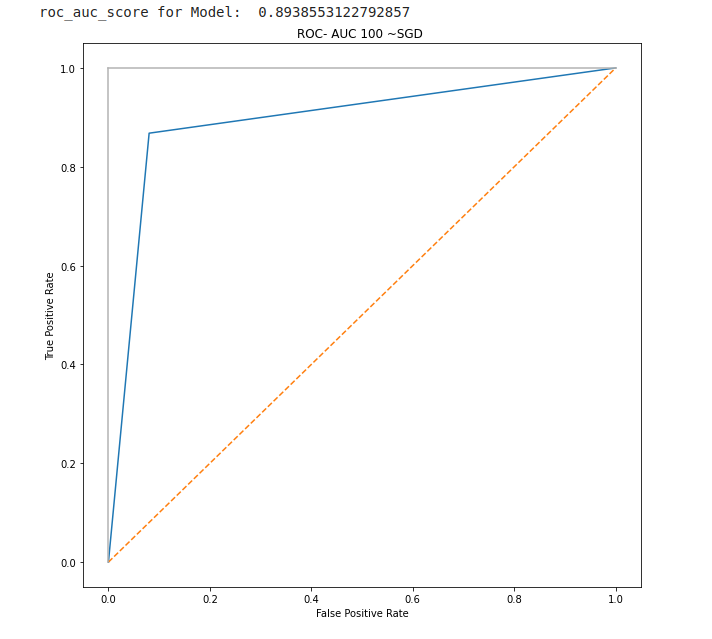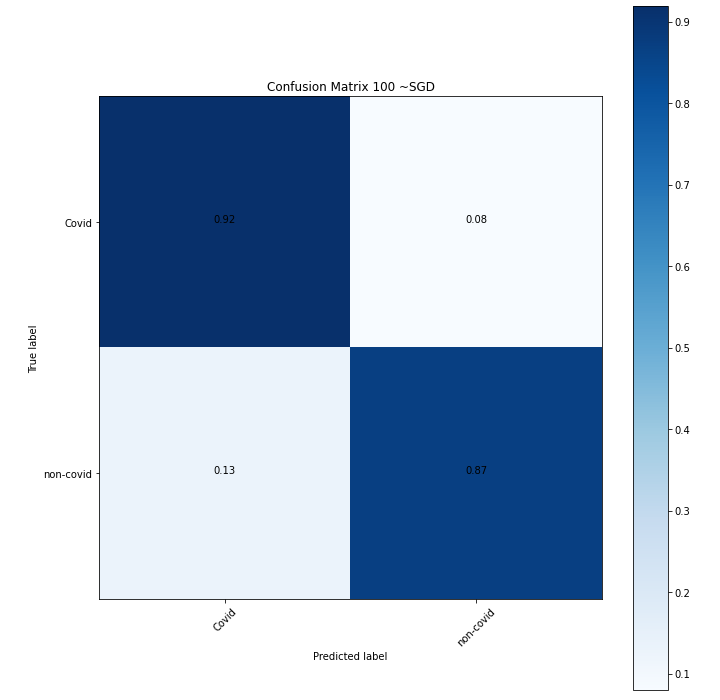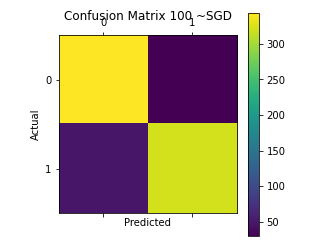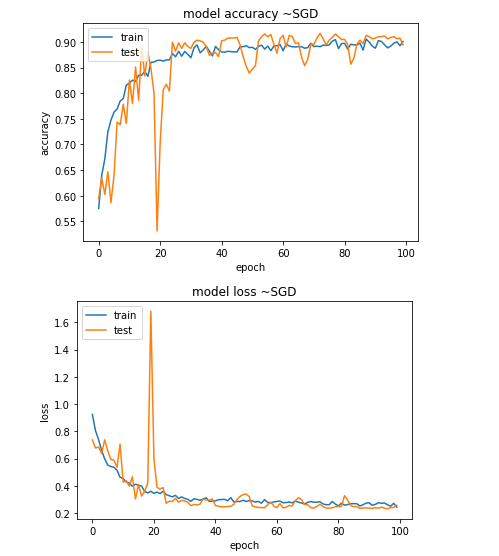

# RMSprop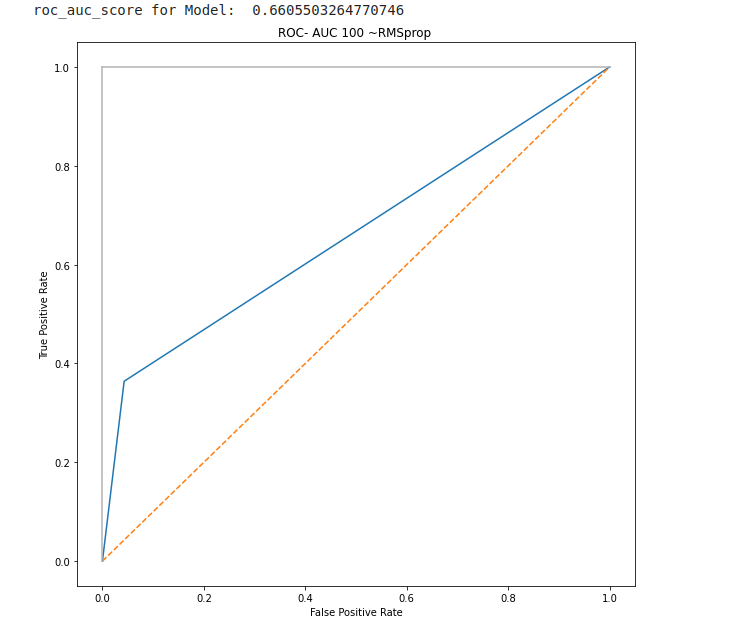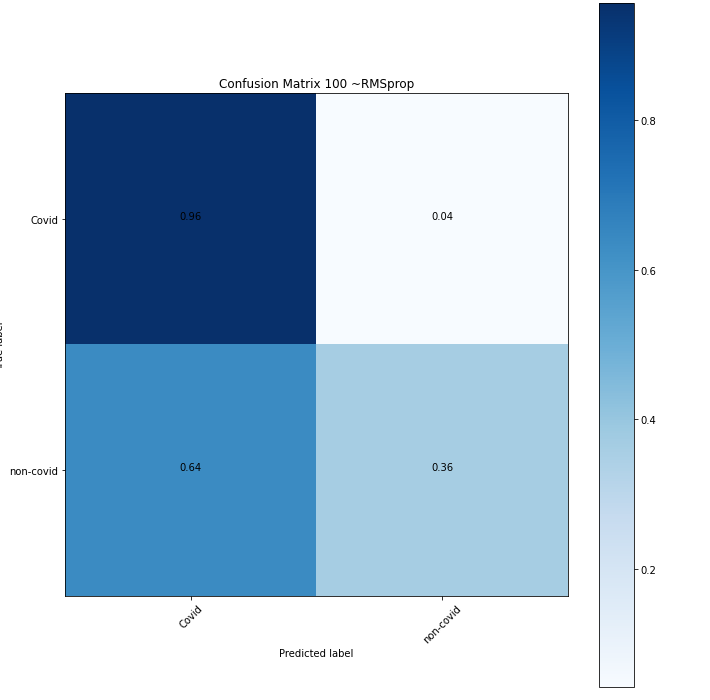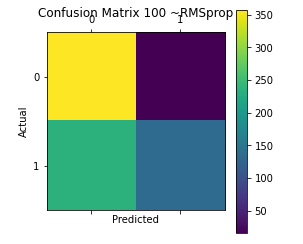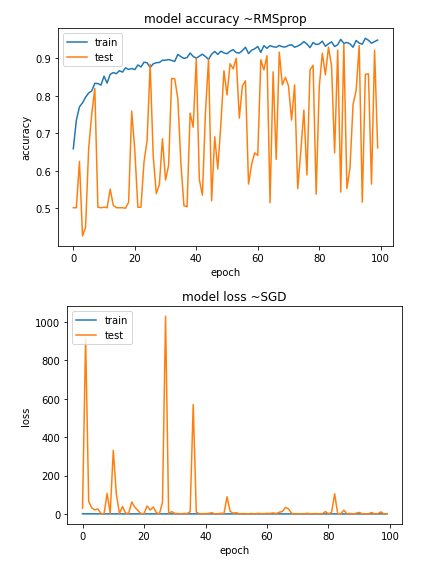

# Adam Graphs
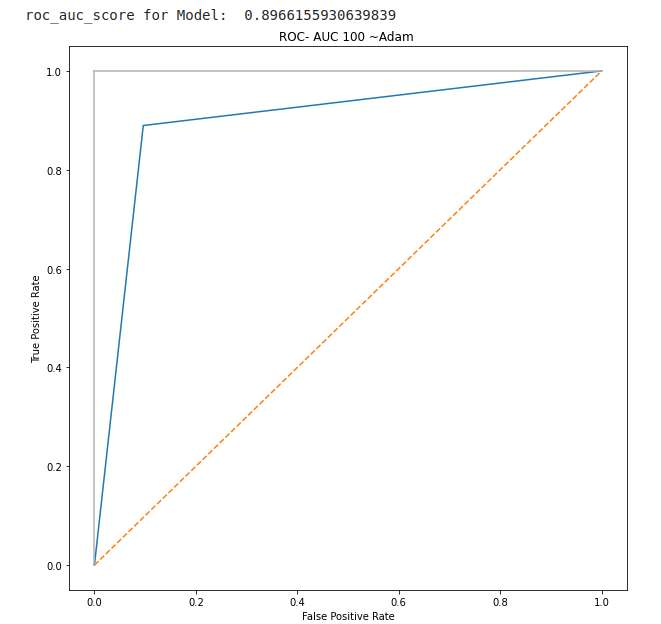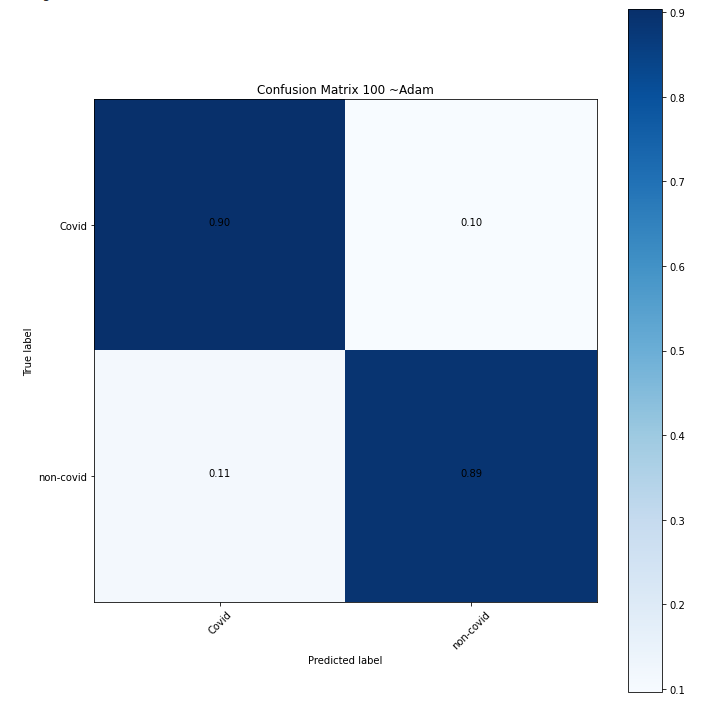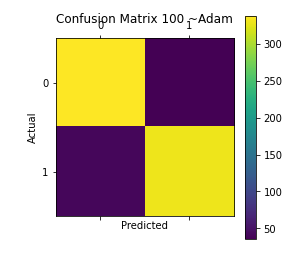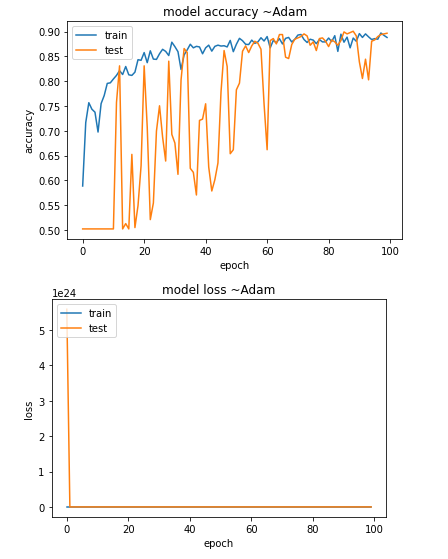

# Adadelta Graphs
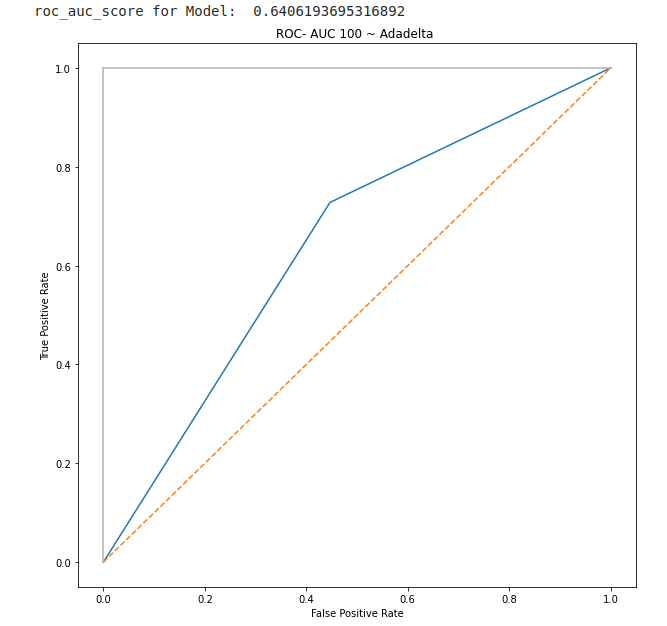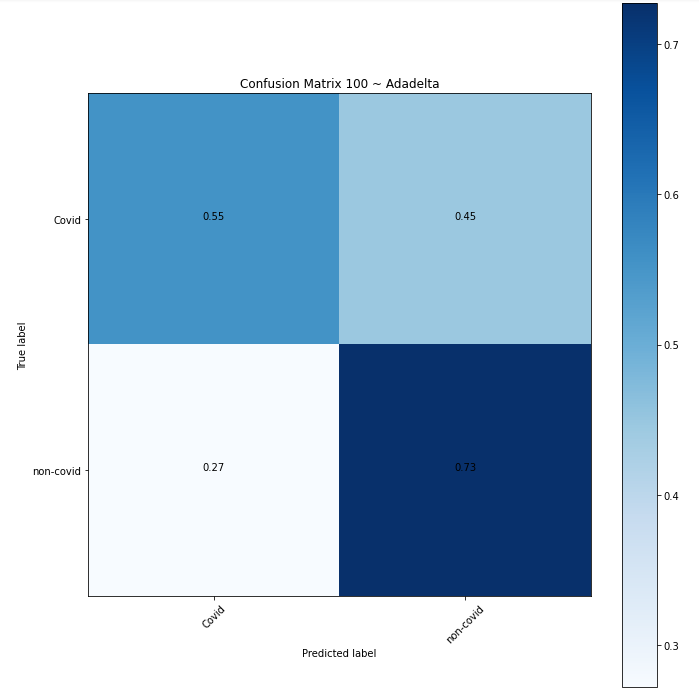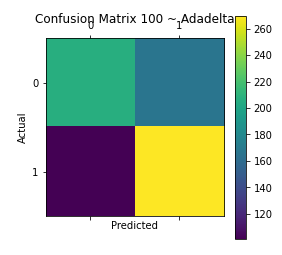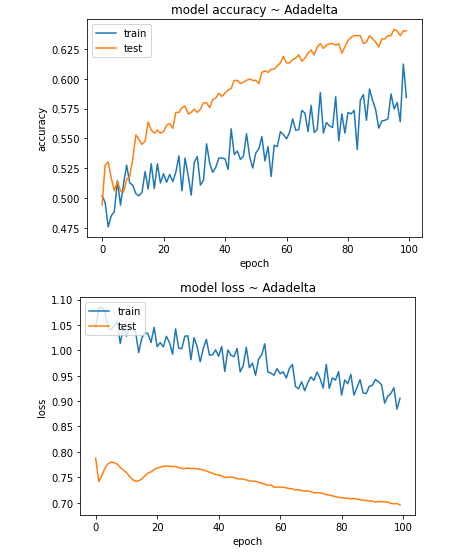

# Adagrad Graphs
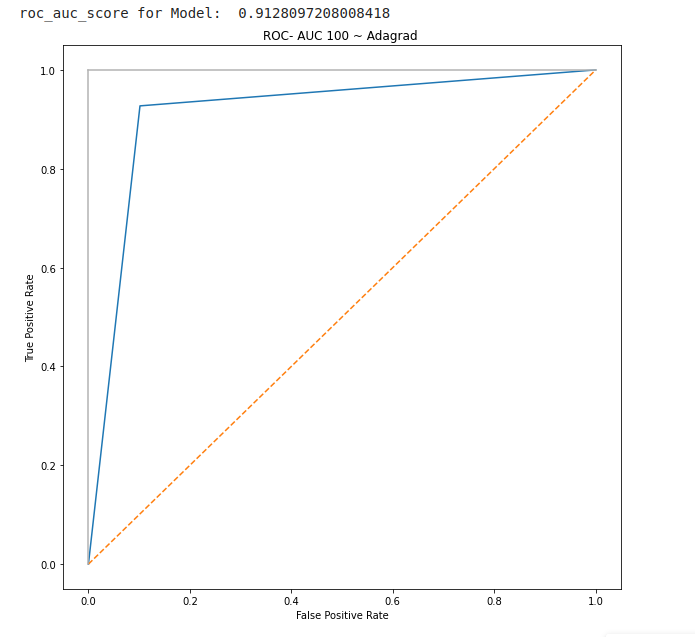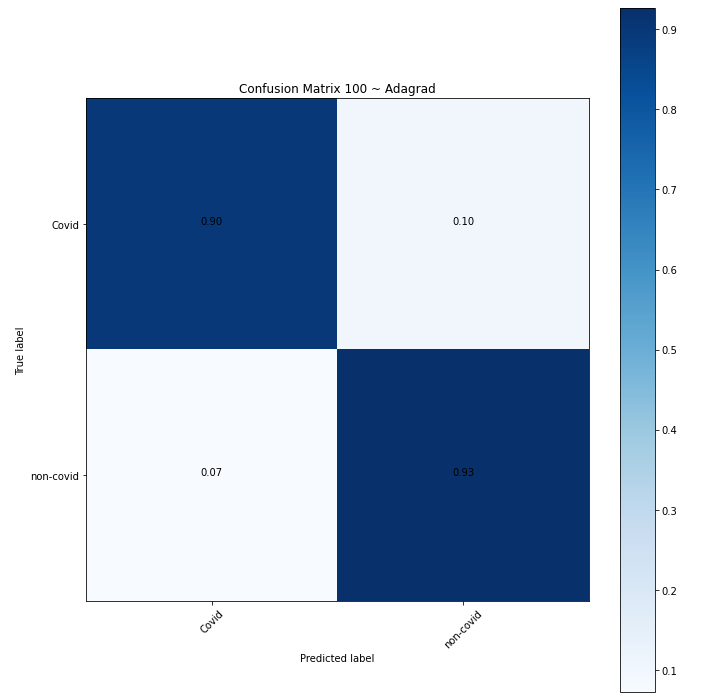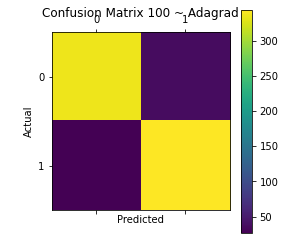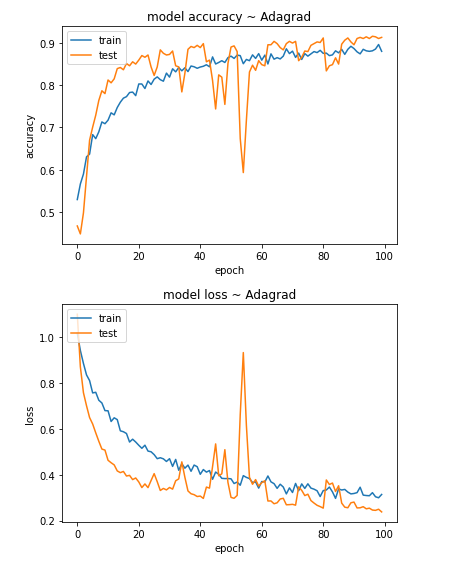

# Nadam Graphs
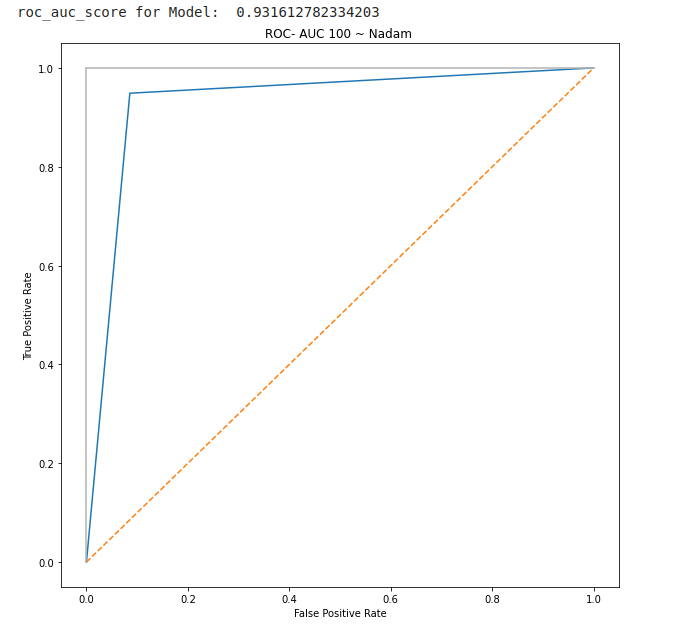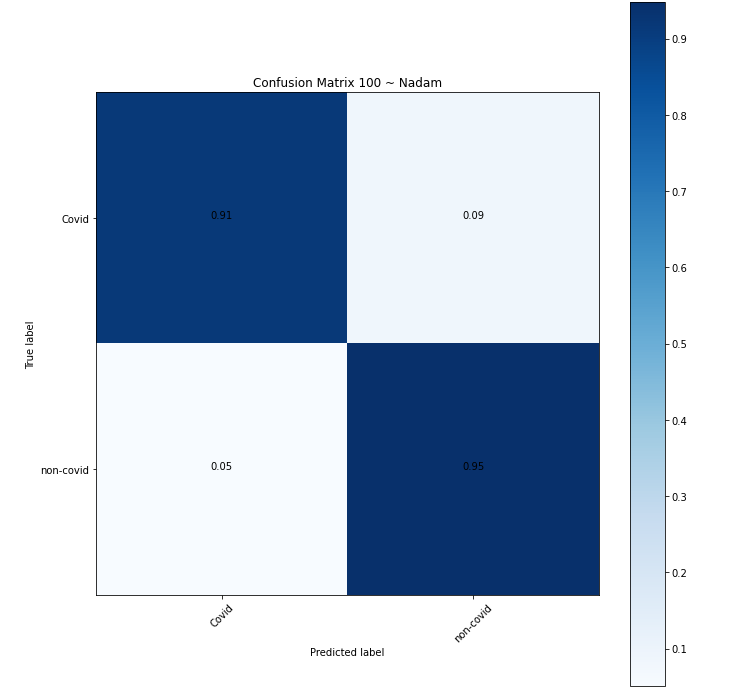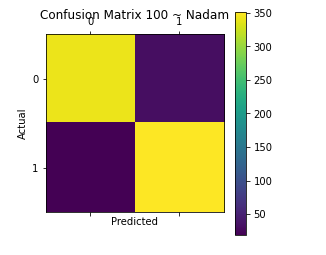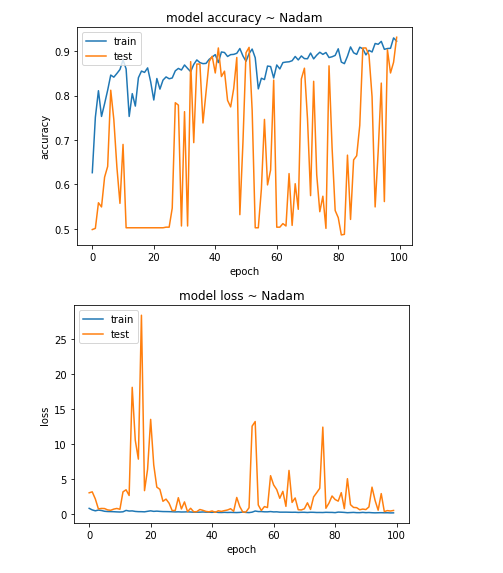